In [1]:
import pandas as pd
import os
import re
import sys
import numpy as np
from merf import MERF
import matplotlib.pyplot as plt
import seaborn as sns
import itertools 
sns.set_context("poster")
from sklearn.ensemble import RandomForestRegressor
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (11,8)
from merf.merf import MERF
from sklearn.model_selection import train_test_split, KFold
from merf.viz import plot_merf_training_stats

current_dir = os.getcwd() # Get the current working directory
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)
from em_utils import *

# Create output directory if it doesn't exist
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_plots/2.taxa"
df_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_dfs/2.taxa"
os.makedirs(output_dir, exist_ok=True)

In [2]:
# Specify the directory where the files are located
data_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/data/taxa/aim2_transformed/genus/merf_ready_sets/"

# Read the CSV files into DataFrames
test_tax_no_na = pd.read_csv(os.path.join(data_dir, 'test_tax_no_na.csv'))
train_tax_no_na = pd.read_csv(os.path.join(data_dir, 'train_tax_no_na.csv'))
full_train_tax = pd.read_csv(os.path.join(data_dir, 'full_train_tax.csv'))
full_test_tax = pd.read_csv(os.path.join(data_dir, 'full_test_tax.csv'))

# Optionally, print the shapes of the DataFrames to confirm they were read correctly
print("test_tax_no_na shape:", test_tax_no_na.shape)
print("train_tax_no_na shape:", train_tax_no_na.shape)
print("full_train_tax shape:", full_train_tax.shape)
print("full_test_tax shape:", full_test_tax.shape)

test_tax_no_na shape: (63, 182)
train_tax_no_na shape: (259, 182)
full_train_tax shape: (259, 186)
full_test_tax shape: (63, 186)


In [3]:
print("---------- Select predictors for training set ----------")
train_set = full_train_tax
X = train_set.drop(['t', 'outcome_BMI_fnl', 'all_samples'], axis=1)
X = X.drop(columns=['Unnamed: 0_tax', 'x_t'], errors='ignore')
Y = train_set[['outcome_BMI_fnl']]
Y = Y['outcome_BMI_fnl'].to_numpy() # Convert Y to numeric array
clusters_train = train_set['all_samples'].to_numpy() # Get ID variables
Z = np.ones((train_set.shape[0], 1)) # Create random effects matrix with ones

print("---------- Select predictors for test set ----------")
test_set = full_test_tax
# Drop any unwanted columns and align test set features with training features
X_new = test_set.drop(['t', 'outcome_BMI_fnl', 'all_samples'], axis=1)  # Drop non-predictor columns
X_new = X_new[X.columns]  # Reorder and select columns to match training set
X_new = X_new.astype(X.dtypes)  # Ensure data types match
X_new = X_new.drop(columns=['Unnamed: 0_tax', 'x_t'], errors='ignore')
X_new = X_new.drop(columns=['Unnamed: 0', 'character_id', 'timepoint'], errors='ignore')

Y_new = test_set['outcome_BMI_fnl'].to_numpy()  # Convert Y to numeric array
clusters_new = pd.Series(test_set['all_samples'])  # Convert to pandas Series
# Create random effects matrix with ones
Z_new = np.ones((len(X_new), 1))

---------- Select predictors for training set ----------
---------- Select predictors for test set ----------


# read in param value file and set grids 

In [4]:
# Read the CSV file
#df = pd.read_csv('/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_dfs/1.clinical/dec5_maggie_params_tuning_raw_clinical_oob.csv')
df = pd.read_csv(os.path.join(df_dir, 'dec6_maggie_params_tuning_raw_taxa_oob.csv'))
# Find the row with the lowest mean_mse_score
lowest_mse_row = df.loc[df['mean_mse_score'].idxmin()]
print("First 5 columns for the lowest mean_mse_score:")
print(lowest_mse_row.iloc[:5])

# Find the row with the lowest mean_prev_score
lowest_prev_row = df.loc[df['mean_prev'].idxmin()]
print("First 5 columns for the lowest mean_prev_score:")
print(lowest_prev_row.iloc[:5])

# Find the row with the lowest mean_prev_score
lowest_ptev_row = df.loc[df['mean_ptev'].idxmin()]
print("First 5 columns for the lowest mean_ptev_score:")
print(lowest_ptev_row.iloc[:5])

# Find the row with the highest oob_score
highest_oob_row = df.loc[df['oob_score'].idxmax()]
print("\nFirst 5 columns for the highest oob_score:")
print(highest_oob_row.iloc[:5])

First 5 columns for the lowest mean_mse_score:
n_estimators         100.0
max_depth              NaN
min_samples_split      0.1
max_iter               2.0
n_splits              10.0
Name: 8, dtype: float64
First 5 columns for the lowest mean_prev_score:
n_estimators         1000.0
max_depth               NaN
min_samples_split       0.1
max_iter                2.0
n_splits                5.0
Name: 43, dtype: float64
First 5 columns for the lowest mean_ptev_score:
n_estimators         100.00
max_depth               NaN
min_samples_split      0.05
max_iter              10.00
n_splits               3.00
Name: 3, dtype: float64

First 5 columns for the highest oob_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.05
max_iter               2.00
n_splits               3.00
Name: 18, dtype: float64


In [12]:
# Extract the rows for the parameter grids
lowest_mse_row = df.loc[df['mean_mse_score'].idxmin()]
lowest_prev_row = df.loc[df['mean_prev'].idxmin()]
lowest_ptev_row = df.loc[df['mean_ptev'].idxmin()]
highest_oob_row = df.loc[df['oob_score'].idxmax()]

# Create parameter grids from the extracted rows
best_mse_param_grid = {
    'n_estimators': [int(lowest_mse_row['n_estimators'])],
    #'max_depth': [int(lowest_mse_row['max_depth'])],
    'max_depth': [None if pd.isna(lowest_mse_row['max_depth']) else int(lowest_mse_row['max_depth'])],
    'min_samples_split': [float(lowest_mse_row['min_samples_split'])],
    #'min_samples_split': [float(lowest_mse_row['min_samples_split']) if lowest_mse_row['min_samples_split'] != 0 else 0.0],  # Convert 0 to 0.0
    'max_iter': [int(lowest_mse_row['max_iter'])],
    'n_splits': [int(lowest_mse_row['n_splits'])]
}
print("Best MSE Parameter Grid:")
print("n_estimators:", best_mse_param_grid['n_estimators'][0])
print("max_depth:", best_mse_param_grid['max_depth'][0])
print("min_samples_split:", best_mse_param_grid['min_samples_split'][0])
print("max_iter:", best_mse_param_grid['max_iter'][0])
print("n_splits:", best_mse_param_grid['n_splits'][0])

lowest_prev_param_grid = {
    'n_estimators': [int(lowest_prev_row['n_estimators'])],
    #'max_depth': [int(lowest_prev_row['max_depth'])],
    'max_depth': [None if pd.isna(lowest_prev_row['max_depth']) else int(lowest_prev_row['max_depth'])],
    'min_samples_split': [float(lowest_prev_row['min_samples_split'])],
    'max_iter': [int(lowest_prev_row['max_iter'])],
    'n_splits': [int(lowest_prev_row['n_splits'])]
}
print("\nLowest Prev Parameter Grid:")
print("n_estimators:", lowest_prev_param_grid['n_estimators'][0])
print("max_depth:", lowest_prev_param_grid['max_depth'][0])
print("min_samples_split:", lowest_prev_param_grid['min_samples_split'][0])
print("max_iter:", lowest_prev_param_grid['max_iter'][0])
print("n_splits:", lowest_prev_param_grid['n_splits'][0])

lowest_ptev_param_grid = {
    'n_estimators': [int(lowest_ptev_row['n_estimators'])],
    #'max_depth': [int(lowest_ptev_row['max_depth'])],
    'max_depth': [None if pd.isna(lowest_ptev_row['max_depth']) else int(lowest_ptev_row['max_depth'])],
    'min_samples_split': [float(lowest_ptev_row['min_samples_split'])],
    'max_iter': [int(lowest_ptev_row['max_iter'])],
    'n_splits': [int(lowest_ptev_row['n_splits'])]
}
print("\nLowest PTEV Parameter Grid:")
print("n_estimators:", lowest_ptev_param_grid['n_estimators'][0])
print("max_depth:", lowest_ptev_param_grid['max_depth'][0])
print("min_samples_split:", lowest_ptev_param_grid['min_samples_split'][0])
print("max_iter:", lowest_ptev_param_grid['max_iter'][0])
print("n_splits:", lowest_ptev_param_grid['n_splits'][0])

highest_oob_param_grid = {
    'n_estimators': [int(highest_oob_row['n_estimators'])],
    'max_depth': [None if pd.isna(highest_oob_row['max_depth']) else int(highest_oob_row['max_depth'])],
    'min_samples_split': [float(highest_oob_row['min_samples_split'])],
    'max_iter': [int(highest_oob_row['max_iter'])],
    'n_splits': [int(highest_oob_row['n_splits'])]
}
print("\Highest OOB Parameter Grid:")
print("n_estimators:", highest_oob_row['n_estimators'])
print("max_depth:", highest_oob_row['max_depth'])
print("min_samples_split:", highest_oob_row['min_samples_split'])
print("max_iter:", highest_oob_row['max_iter'])
print("n_splits:", highest_oob_row['n_splits'])

Best MSE Parameter Grid:
n_estimators: 100
max_depth: None
min_samples_split: 0.1
max_iter: 2
n_splits: 10

Lowest Prev Parameter Grid:
n_estimators: 1000
max_depth: None
min_samples_split: 0.1
max_iter: 2
n_splits: 5

Lowest PTEV Parameter Grid:
n_estimators: 100
max_depth: None
min_samples_split: 0.05
max_iter: 10
n_splits: 3
\Highest OOB Parameter Grid:
n_estimators: 500.0
max_depth: nan
min_samples_split: 0.05
max_iter: 2.0
n_splits: 3.0


<>:61: SyntaxWarning: invalid escape sequence '\H'
<>:61: SyntaxWarning: invalid escape sequence '\H'
/var/folders/4l/kqxc4rwn4lj10fzv9hw4xxsr0000gn/T/ipykernel_59546/2937010470.py:61: SyntaxWarning: invalid escape sequence '\H'
  print("\Highest OOB Parameter Grid:")


In [13]:
# Create MERF models for each parameter grid
mse_merf = MERF(fixed_effects_model =
           RandomForestRegressor(n_estimators = best_mse_param_grid['n_estimators'][0], 
                                max_depth = best_mse_param_grid['max_depth'][0], 
                                min_samples_split = best_mse_param_grid['min_samples_split'][0], 
                                n_jobs = 1, 
                                oob_score= True),
            gll_early_stop_threshold=None,
            max_iterations = best_mse_param_grid['max_iter'][0])

prev_merf = MERF(fixed_effects_model =
           RandomForestRegressor(n_estimators = lowest_prev_param_grid['n_estimators'][0], 
                                max_depth = lowest_prev_param_grid['max_depth'][0], 
                                min_samples_split = lowest_prev_param_grid['min_samples_split'][0], 
                                n_jobs = 1, 
                                oob_score= True),
            gll_early_stop_threshold=None,
            max_iterations = lowest_prev_param_grid['max_iter'][0])

ptev_merf = MERF(fixed_effects_model =
           RandomForestRegressor(n_estimators = lowest_ptev_param_grid['n_estimators'][0], 
                                max_depth = lowest_ptev_param_grid['max_depth'][0], 
                                min_samples_split = lowest_ptev_param_grid['min_samples_split'][0], 
                                n_jobs = 1, 
                                oob_score= True),
            gll_early_stop_threshold=None,
            max_iterations = lowest_ptev_param_grid['max_iter'][0])

oob_merf = MERF(fixed_effects_model =
           RandomForestRegressor(n_estimators = highest_oob_param_grid['n_estimators'][0], 
                                max_depth = highest_oob_param_grid['max_depth'][0], 
                                min_samples_split = highest_oob_param_grid['min_samples_split'][0], 
                                n_jobs = 1, 
                                oob_score= True),
            gll_early_stop_threshold=None,
            max_iterations = highest_oob_param_grid['max_iter'][0])

In [14]:
print("---------- RUN MERF RAW WITH TUNING PARAMETERS 🌱 ----------")
mrf_mse = mse_merf.fit(X.select_dtypes(include=[np.number]), 
        Z, 
        pd.Series(clusters_train), 
        Y)

mrf_prev = prev_merf.fit(X.select_dtypes(include=[np.number]), 
        Z, 
        pd.Series(clusters_train), 
        Y)

mrf_ptev = ptev_merf.fit(X.select_dtypes(include=[np.number]), 
        Z, 
        pd.Series(clusters_train), 
        Y)

mrf_oob = oob_merf.fit(X.select_dtypes(include=[np.number]), 
                Z, 
                pd.Series(clusters_train), 
                Y)

---------- RUN MERF RAW WITH TUNING PARAMETERS 🌱 ----------


INFO     [merf.py:307] Training GLL is 641.7758048401992 at iteration 1.
INFO     [merf.py:307] Training GLL is 678.7622972866044 at iteration 2.
INFO     [merf.py:307] Training GLL is 638.5683631657407 at iteration 1.
INFO     [merf.py:307] Training GLL is 674.3866972494327 at iteration 2.
INFO     [merf.py:307] Training GLL is 468.2819370713513 at iteration 1.
INFO     [merf.py:307] Training GLL is 527.3372805843318 at iteration 2.
INFO     [merf.py:307] Training GLL is 523.3206230918189 at iteration 3.
INFO     [merf.py:307] Training GLL is 535.76105968879 at iteration 4.
INFO     [merf.py:307] Training GLL is 526.351245240352 at iteration 5.
INFO     [merf.py:307] Training GLL is 532.4231042330714 at iteration 6.
INFO     [merf.py:307] Training GLL is 517.1492060893629 at iteration 7.
INFO     [merf.py:307] Training GLL is 516.2914463396411 at iteration 8.
INFO     [merf.py:307] Training GLL is 518.4029463424256 at iteration 9.
INFO     [merf.py:307] Training GLL is 529.20003858531

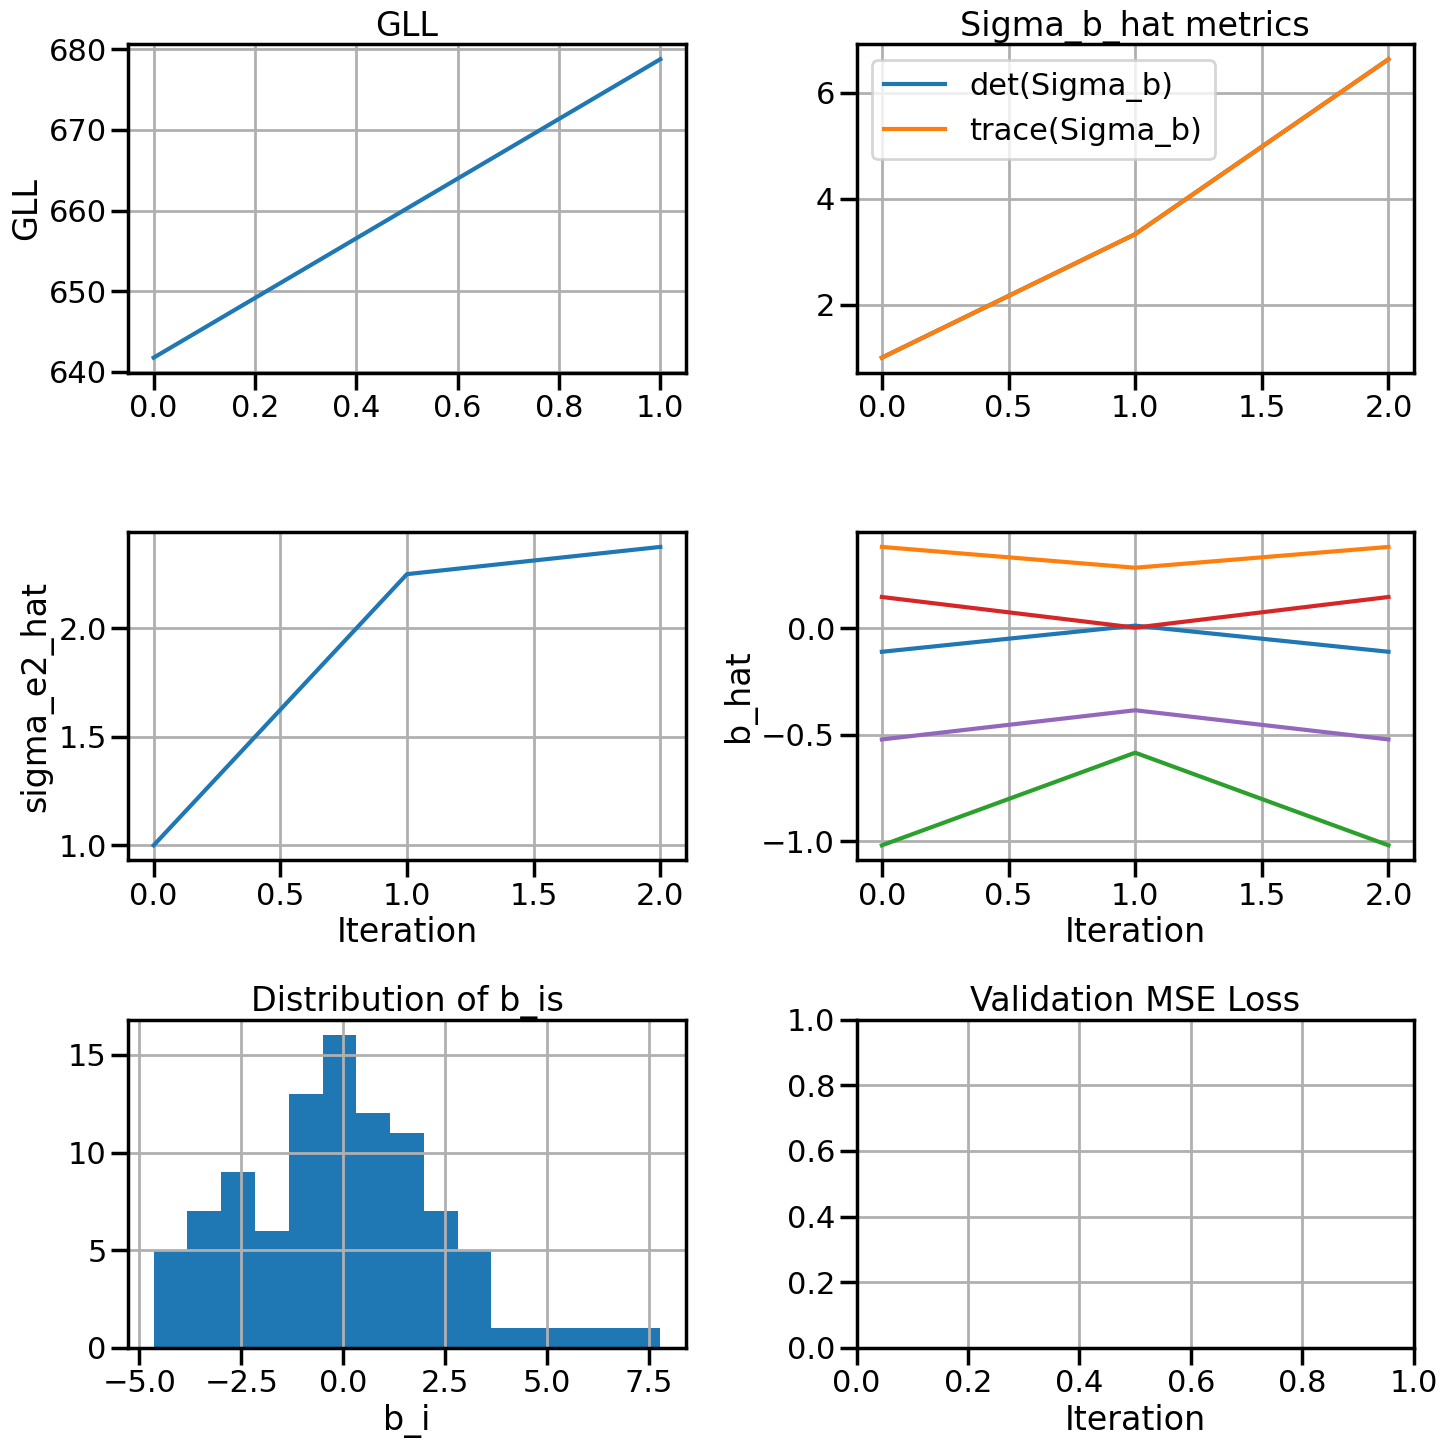

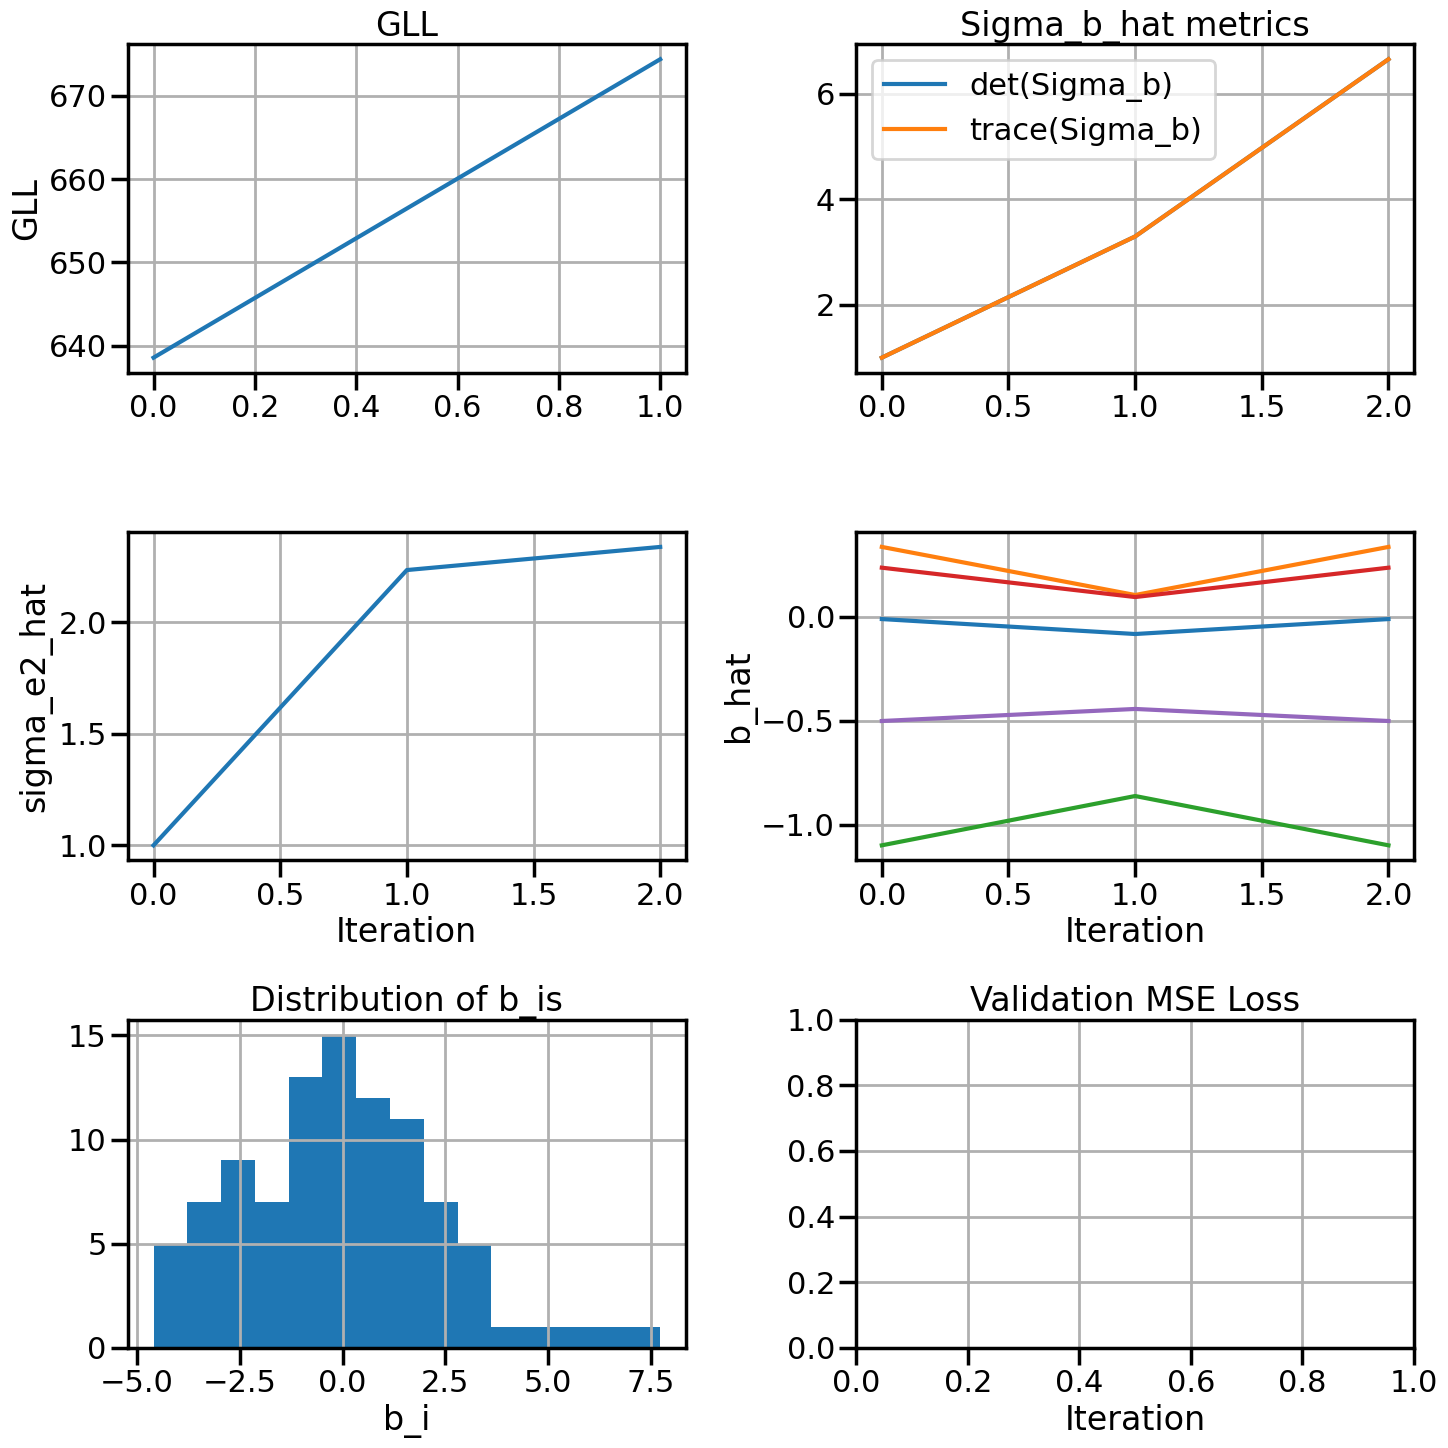

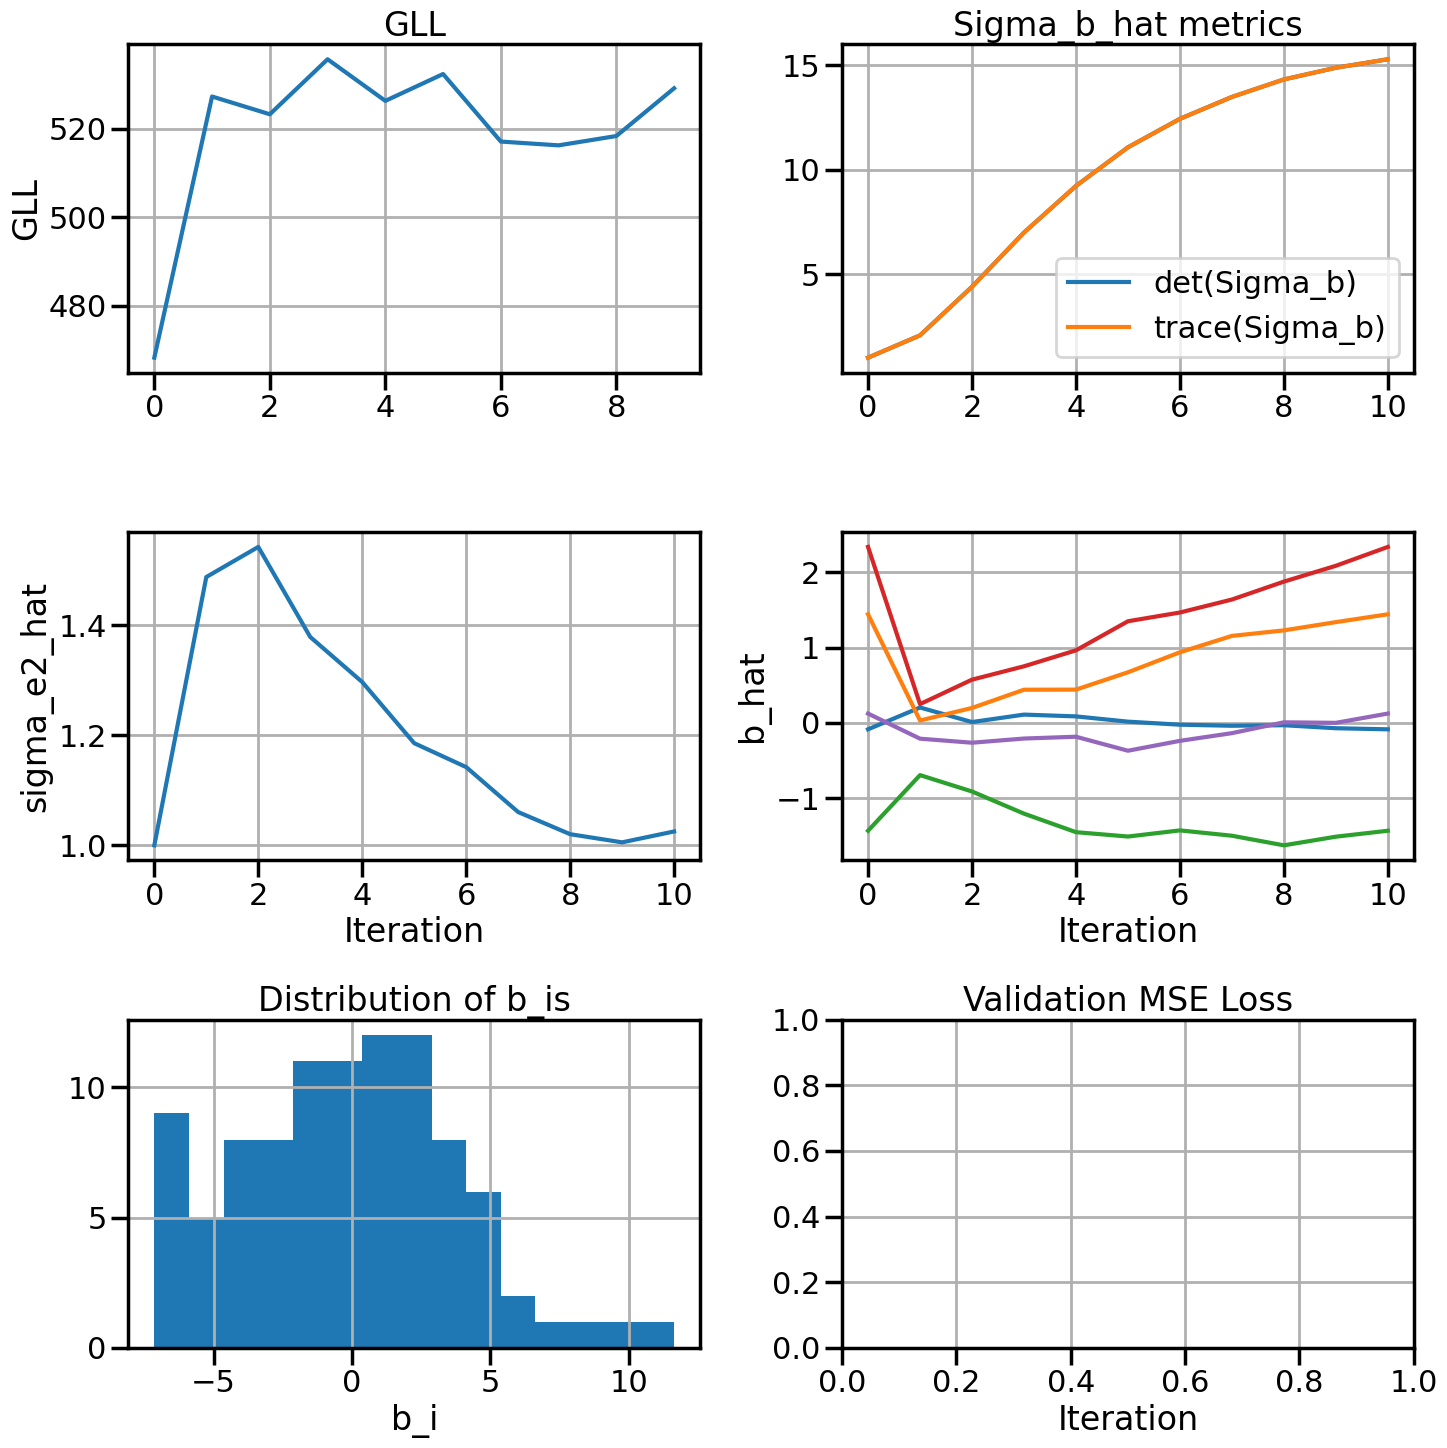

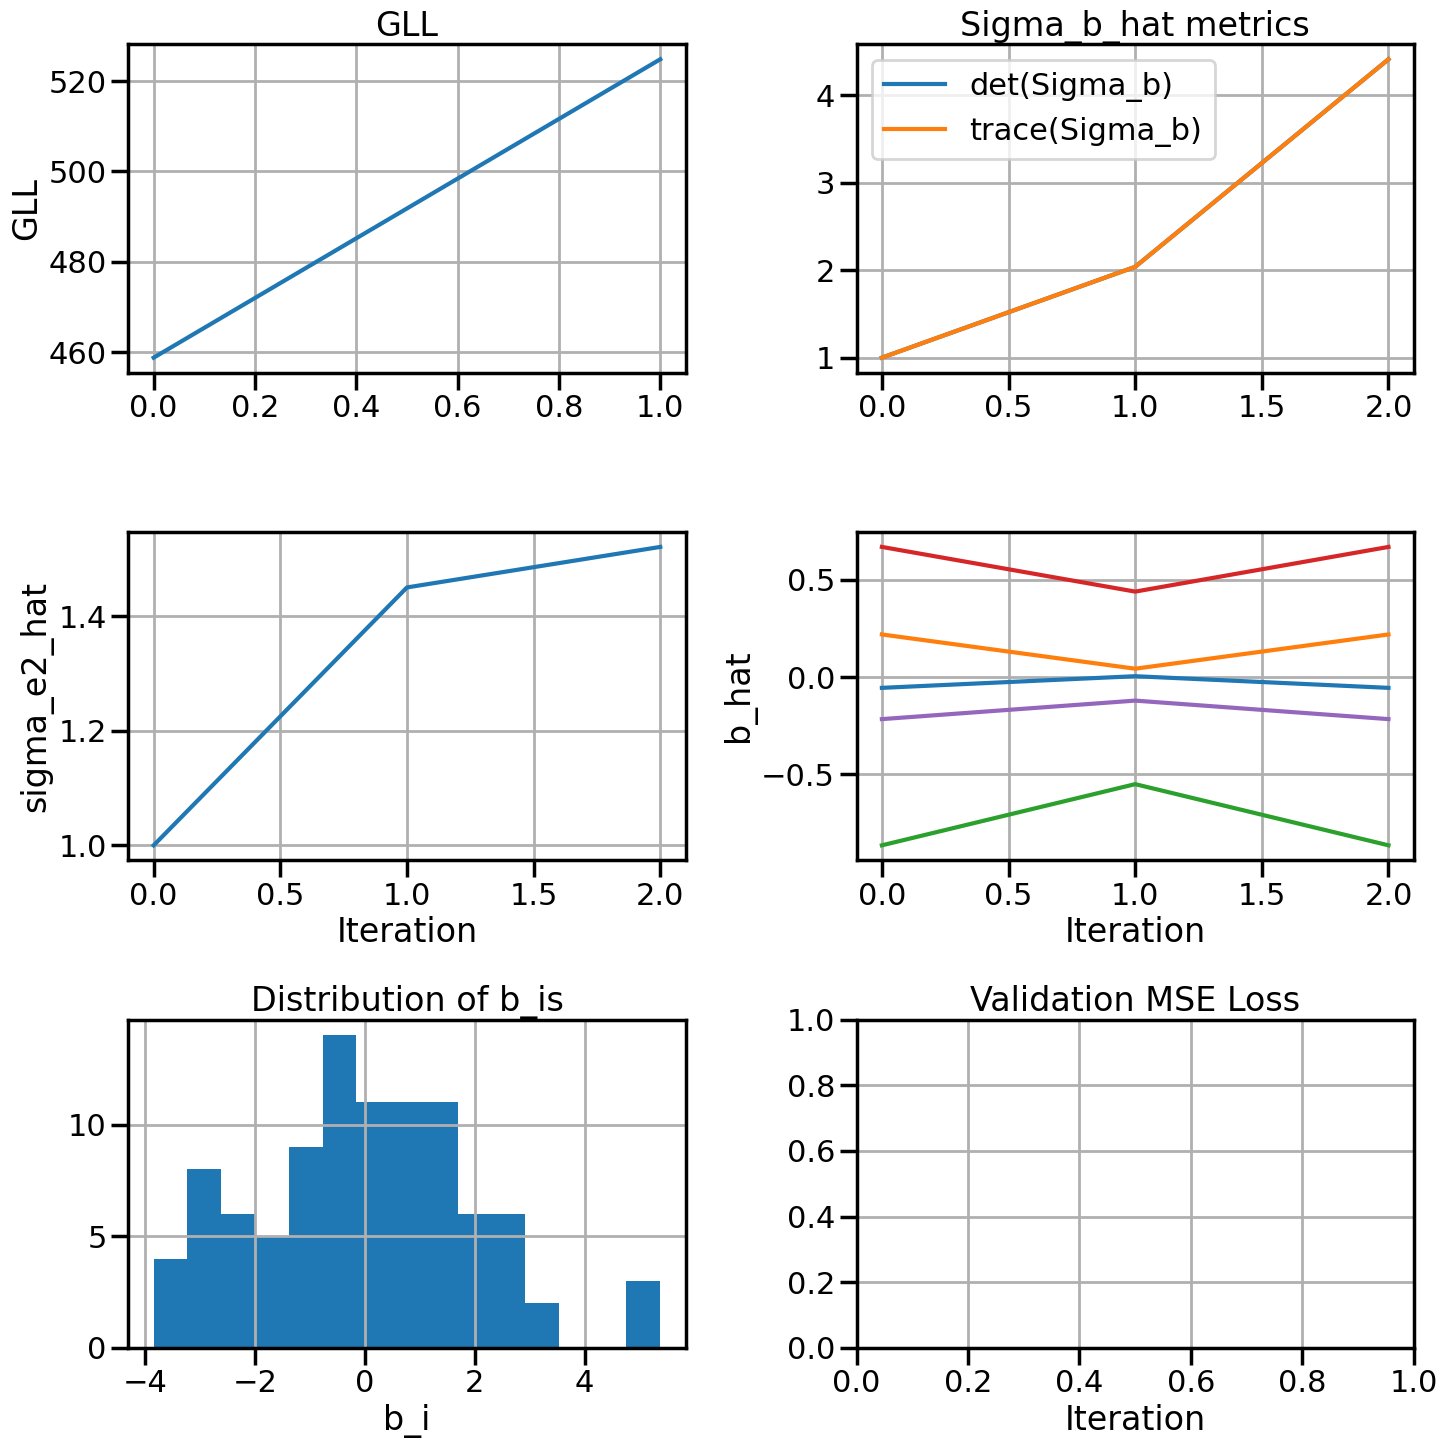

In [15]:
plot_merf_training_stats(mrf_mse)
plt.savefig(os.path.join(output_dir, 'dec6_cv_tuned_mse_merf_raw_metrics_taxa.png'), dpi=300, bbox_inches='tight')

plot_merf_training_stats(mrf_prev)
plt.savefig(os.path.join(output_dir, 'dec6_cv_tuned_prev_merf_raw_metrics_taxa.png'), dpi=300, bbox_inches='tight')

plot_merf_training_stats(mrf_ptev)
plt.savefig(os.path.join(output_dir, 'dec6_cv_tuned_ptev_merf_raw_metrics_taxa.png'), dpi=300, bbox_inches='tight')

plot_merf_training_stats(mrf_oob)
plt.savefig(os.path.join(output_dir, 'dec6_cv_tuned_oob_merf_raw_metrics_taxa.png'), dpi=300, bbox_inches='tight')

# Now use grid search parameter models on test sets 

In [16]:
# Predict using the fitted model
X_new = X_new.drop(columns=['x_t'], errors='ignore')
y_hat_new_mse = mrf_mse.predict(X_new, Z_new, clusters_new)
forest_mse = mrf_mse.trained_fe_model
oob_score_mse = round(forest_mse.oob_score_*100, 1)

y_hat_new_prev = mrf_prev.predict(X_new, Z_new, clusters_new)
forest_prev = mrf_prev.trained_fe_model
oob_score_prev = round(forest_prev.oob_score_*100, 1)

y_hat_new_ptev = mrf_ptev.predict(X_new, Z_new, clusters_new)
forest_ptev = mrf_ptev.trained_fe_model
oob_score_ptev = round(forest_ptev.oob_score_*100, 1)

y_hat_new_oob = mrf_oob.predict(X_new, Z_new, clusters_new)
forest_oob = mrf_oob.trained_fe_model
oob_score_tuned = round(forest_oob.oob_score_*100, 1)

# Plot predicted vs actual

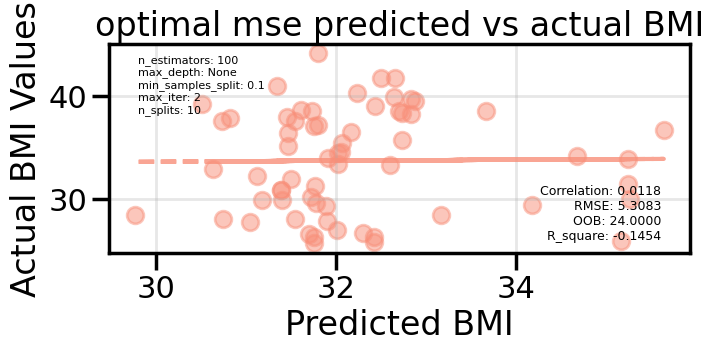

In [17]:
plot_predicted_vs_actual(y_hat_new_mse, Y_new,
                         output_dir, 'dec6_cv_taxa_predicted_vs_actual_mse_tuned.png', 
                         best_mse_param_grid, oob_score_mse, '#F88F79', 'optimal mse predicted vs actual BMI')

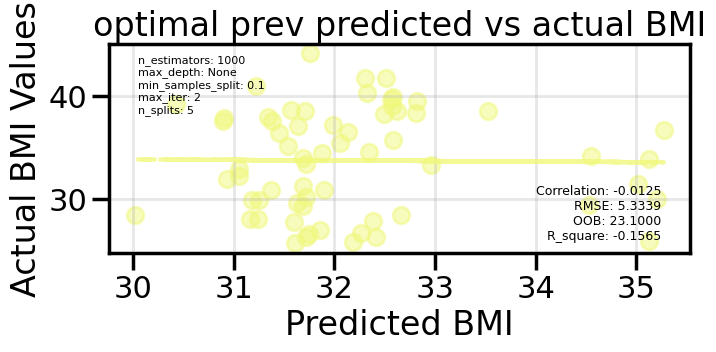

In [18]:
plot_predicted_vs_actual(y_hat_new_prev, Y_new,
                         output_dir, 'dec6_cv_taxa_predicted_vs_actual_prev_tuned.png', 
                         lowest_prev_param_grid, oob_score_prev, '#F0F879', 'optimal prev predicted vs actual BMI')

Correlation between actual and predicted values: 0.2551
Root Mean Squared Error: 5.0661
R-squared Score: -0.0433


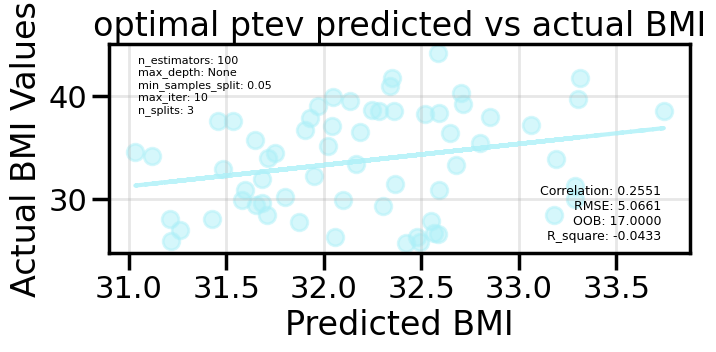

In [19]:
calculate_metrics(Y_new, y_hat_new_ptev) #(Y_true, Y_pred)
plot_predicted_vs_actual(y_hat_new_ptev, Y_new,
                         output_dir, 'dec6_cv_taxa_predicted_vs_actual_ptev_tuned.png', 
                         lowest_ptev_param_grid, oob_score_ptev, '#ACF0F8', 'optimal ptev predicted vs actual BMI')

Correlation between actual and predicted values: 0.0153
Root Mean Squared Error: 5.3073
R-squared Score: -0.1449


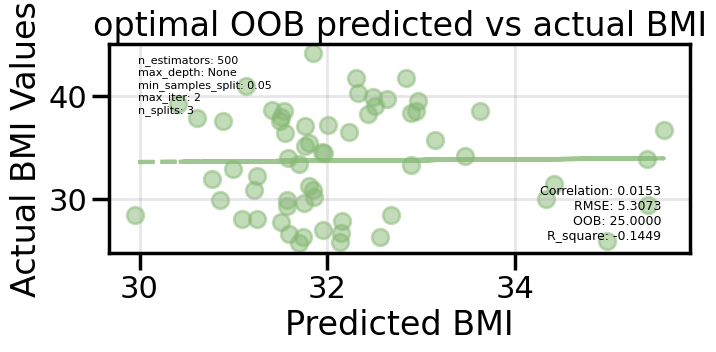

In [20]:
calculate_metrics(Y_new, y_hat_new_oob) #(Y_true, Y_pred)
plot_predicted_vs_actual(y_hat_new_oob, Y_new,
                         output_dir, 'dec6_cv_taxa_predicted_vs_actual_oob_tuned.png', 
                         highest_oob_param_grid, oob_score_tuned, '#86B874', 'optimal OOB predicted vs actual BMI')

# Look at feature importances 

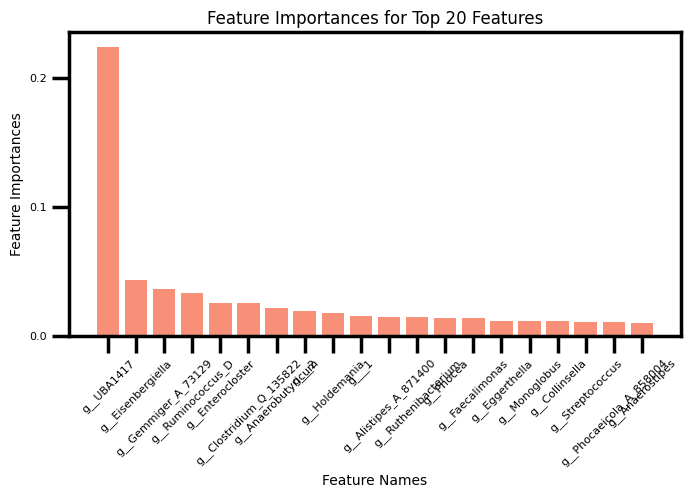

In [21]:
# mse
mse_forest = mrf_mse.trained_fe_model
mse_feature_names = mse_forest.feature_names_in_
mse_feature_importances = mse_forest.feature_importances_
plot_top_20_feature_importances(mse_feature_names, mse_feature_importances, 
                         output_dir, 'dec6_mse_feature_importances_taxa', '#F88F79')

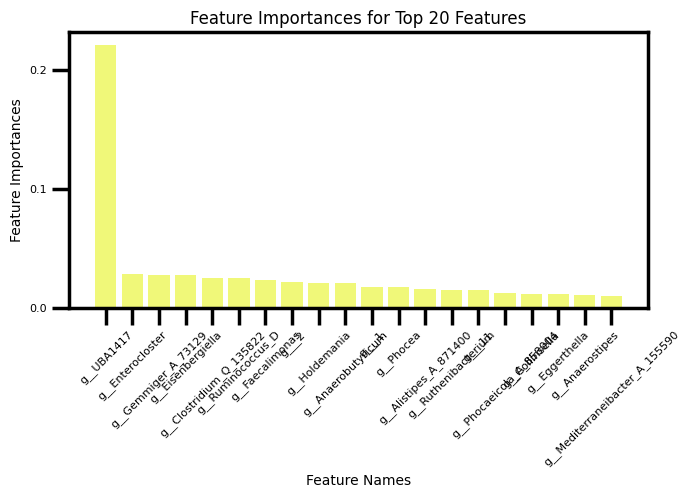

In [22]:
prev_forest = prev_merf.trained_fe_model
prev_feature_names = prev_forest.feature_names_in_
prev_feature_importances = prev_forest.feature_importances_
plot_top_20_feature_importances(prev_feature_names, prev_feature_importances, 
                         output_dir, 'dec6_prev_feature_importances_taxa', '#F0F879')

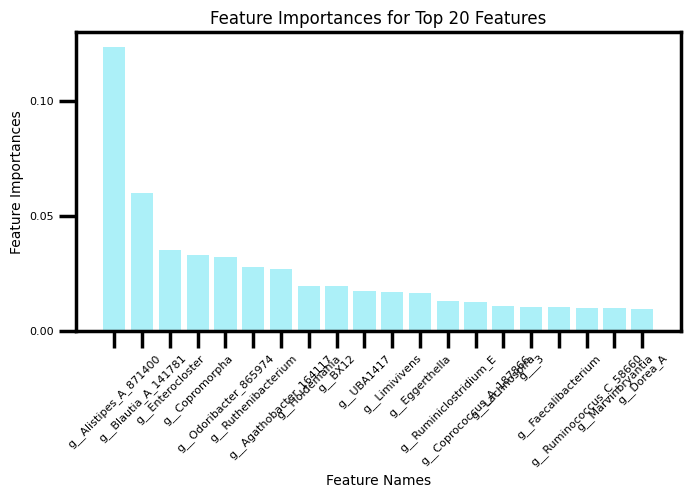

In [23]:
ptev_forest = ptev_merf.trained_fe_model
ptev_feature_names = ptev_forest.feature_names_in_
ptev_feature_importances = ptev_forest.feature_importances_
plot_top_20_feature_importances(ptev_feature_names, ptev_feature_importances, 
                         output_dir, 'dec6_ptev_feature_importances_taxa', '#ACF0F8')

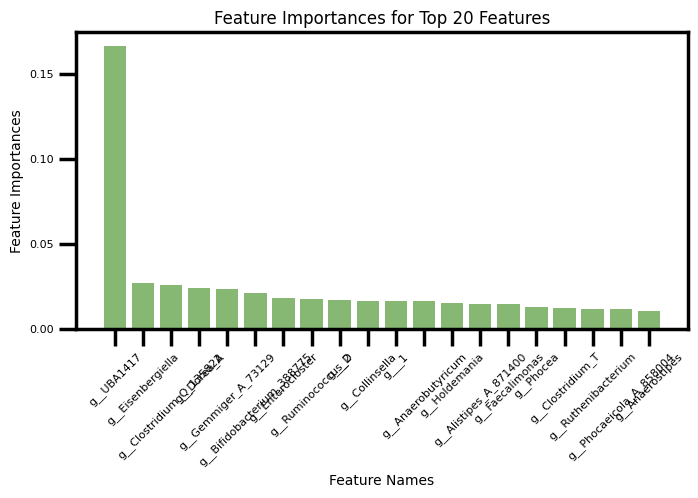

In [24]:
oob_forest = oob_merf.trained_fe_model
oob_feature_names = oob_forest.feature_names_in_
oob_feature_importances = oob_forest.feature_importances_
plot_top_20_feature_importances(oob_feature_names, oob_feature_importances, 
                         output_dir, 'dec6_oob_feature_importances_taxa', '#86B874')